<a href="https://www.kaggle.com/code/shenoudasafwat/voltcast-ai?scriptVersionId=286818206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1-Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
print("Libraries imported successfully!")

Libraries imported successfully!


# 2-Load Data

In [2]:
df = pd.read_csv('/kaggle/input/electric-vehicle-charging-patterns/ev_charging_patterns.csv')

df.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


# 3-Data Inspection

In [3]:
print("Data Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)      

# 4-Smart Feature Engineering

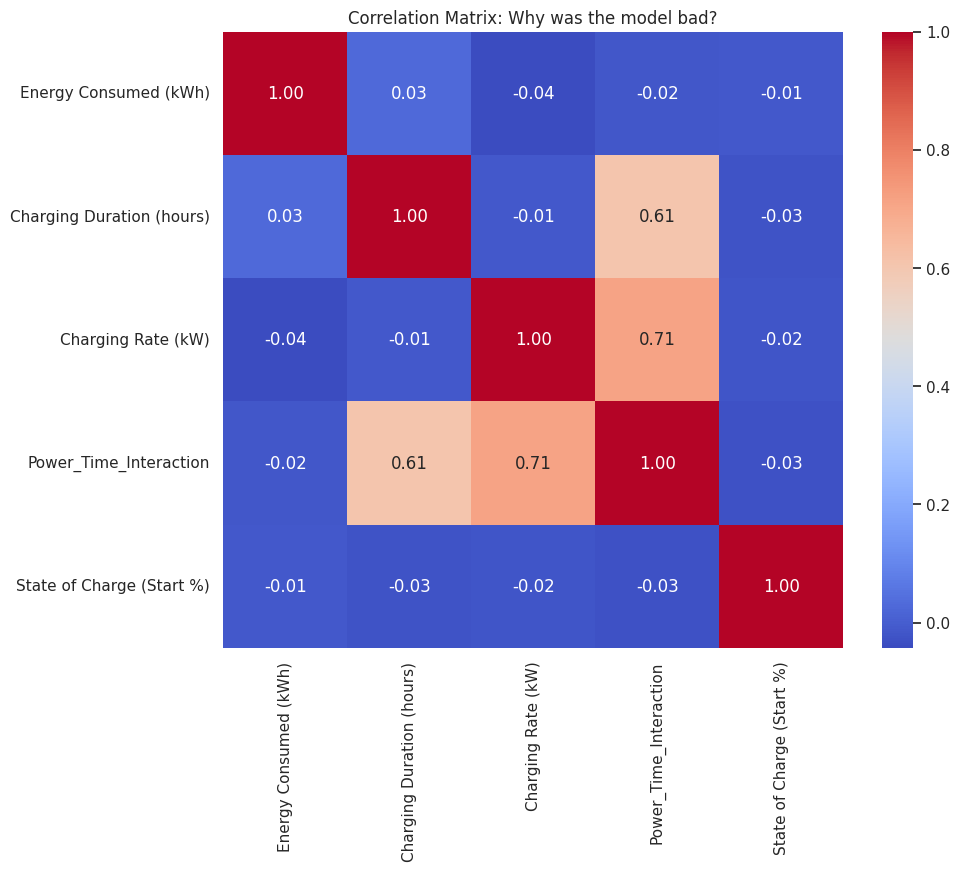

In [4]:
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Start_Hour'] = df['Charging Start Time'].dt.hour
df['Is_Weekend'] = df['Charging Start Time'].dt.dayofweek >= 5

df['Power_Time_Interaction'] = df['Charging Duration (hours)'] * df['Charging Rate (kW)']

df['Efficiency'] = df['Distance Driven (since last charge) (km)'] / (df['Energy Consumed (kWh)'] + 1e-6)

le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

plt.figure(figsize=(10, 8))
cols_to_plot = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 
                'Charging Rate (kW)', 'Power_Time_Interaction', 'State of Charge (Start %)']
sns.heatmap(df[cols_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Why was the model bad?")
plt.show()

# 5-Split Data

In [5]:
print("Original Shape:", df.shape)
df = df.dropna(subset=['Energy Consumed (kWh)'])

df = df[np.isfinite(df['Energy Consumed (kWh)'])]
print("Shape after cleaning target:", df.shape)


drop_cols = ['User ID', 'Charging Station ID', 'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)']

X = df.drop(columns=drop_cols, errors='ignore')
y = df['Energy Consumed (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-" * 30)
print("Data clean and split successfully!")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Original Shape: (1320, 24)
Shape after cleaning target: (1254, 24)
------------------------------
Data clean and split successfully!
Training Shape: (1003, 19)
Testing Shape: (251, 19)


# 6-XGBoost Model

In [6]:
model = xgb.XGBRegressor(
    n_estimators=1000,      
    learning_rate=0.05,     
    max_depth=6,            
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

print("Training model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50, 
    verbose=False
)
print("Training Done!")

Training model...
Training Done!


# 7-Evaluation 

In [7]:
predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kWh")
print(f"R^2 Score (Accuracy): {r2:.4f}")

Root Mean Squared Error (RMSE): 5.78 kWh
R^2 Score (Accuracy): 0.9262


#  8-actual VS expected values

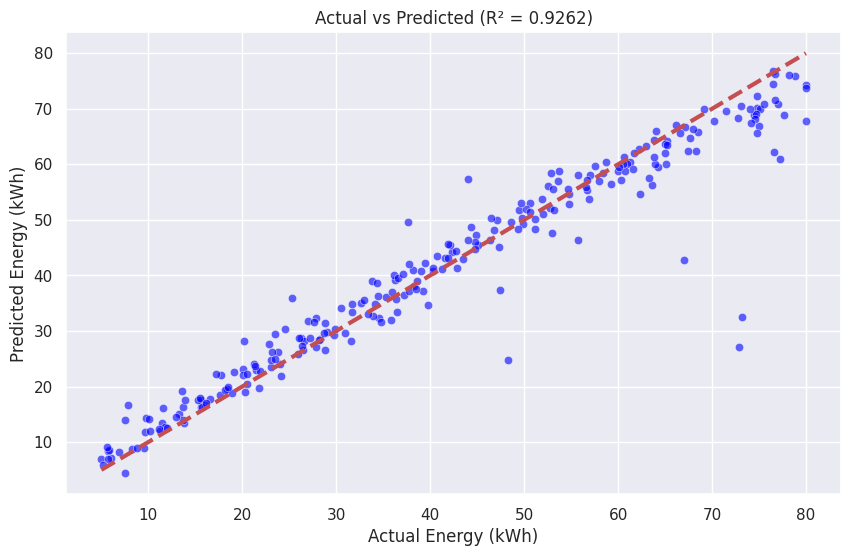

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)

plt.xlabel('Actual Energy (kWh)')
plt.ylabel('Predicted Energy (kWh)')
plt.title(f'Actual vs Predicted (R² = {r2:.4f})')
plt.show()

# 9-Residuals

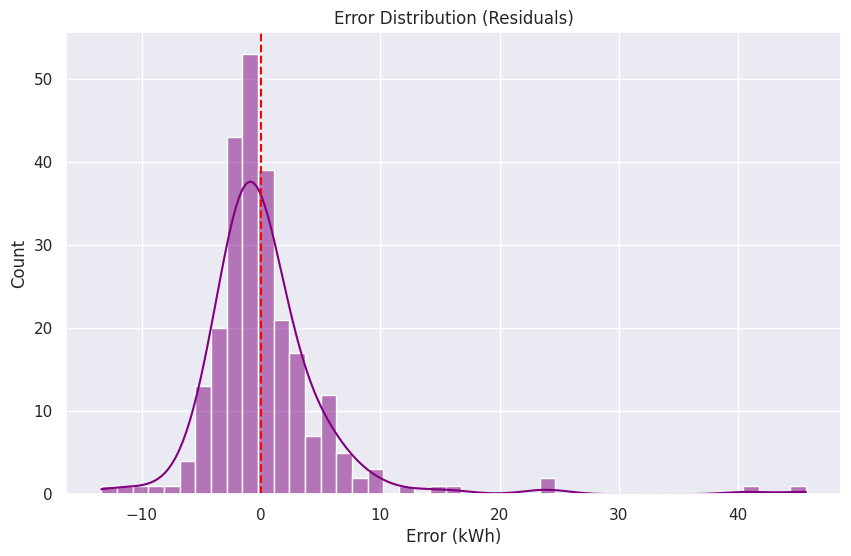

In [9]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Error Distribution (Residuals)') 
plt.xlabel('Error (kWh)')
plt.axvline(0, color='red', linestyle='--') 

# 10- [Shenouda Safwat](https://www.linkedin.com/in/shenouda-safwat/)